In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import time
from IPython.display import clear_output  # 引入 clear_output
# torch.manual_seed(seed=42)  

os.makedirs("fun_images", exist_ok=True)


In [9]:
layer_num=4
hidden_num=128

class Mynetwork(nn.Module):
    def __init__(self,input_num=1 , out_num=1,hidden_num=128):
        super().__init__()
        self.MLP=nn.Sequential(
            nn.Linear(input_num, hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,out_num),
        )
        pass
    def forward(self,x):
        return self.MLP(x)

In [10]:
def potential(x):
    poten=2*x**2+3*torch.sin(torch.pi*x/2.4)*x*(1-torch.exp(-x/6))
    return poten

In [11]:
#需要适当减小,x_M=sqrt(h_bar/(m*w)*(2n+1)),考虑要>10x_M,700sqrt(h_bar/\omega*m)
h_bar=1
m=1
b_lap:float=-h_bar**2/(2*m)

# 同时对于库伦势函数, 取e=1, 4\pi\epsilon_0=1, E_n=-1/(2n^2)
dtype=torch.float32
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

La =0
Lb =20
L=Lb-La  # domain length
N = 800   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device,requires_grad=True)
grid=grid[1:-1].unsqueeze(-1)

en_num=100

#离心势能：-k*(l+1)*l/x**2

# 先给出固定的矩阵元素
diag = -2.0 / h**2 * torch.ones(N,device=device) * b_lap
off_diag = 1.0 / h**2 * torch.ones(N - 1,device=device) * b_lap


In [12]:
l=0
centrifugal_poten=-b_lap*(l+1)*l/grid**2
V_diag=potential(grid)+centrifugal_poten
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)
real_en=eigenvalues[:en_num]    
print("real_en",real_en)

real_en tensor([  3.2897,   7.5954,  11.4789,  14.9451,  18.2513,  21.6419,  25.2000,
         28.9332,  32.8308,  36.8763,  41.0524,  45.3414,  49.7258,  54.1879,
         58.7099,  63.2736,  67.8594,  72.4467,  77.0126,  81.5309,  85.9706,
         90.2935,  94.4499,  98.3739, 101.9849, 105.2375, 108.2465, 111.2350,
        114.3089, 117.4816, 120.7497, 124.1081, 127.5515, 131.0746, 134.6731,
        138.3427, 142.0798, 145.8808, 149.7426, 153.6620, 157.6363, 161.6625,
        165.7380, 169.8602, 174.0265, 178.2341, 182.4806, 186.7634, 191.0799,
        195.4272, 199.8027, 204.2034, 208.6265, 213.0688, 217.5269, 221.9974,
        226.4765, 230.9601, 235.4436, 239.9221, 244.3900, 248.8407, 253.2669,
        257.6597, 262.0081, 266.2988, 270.5138, 274.6287, 278.6075, 282.3932,
        285.8895, 288.9749, 291.7256, 294.4894, 297.3829, 300.3735, 303.4473,
        306.5952, 309.8096, 313.0847, 316.4160, 319.7995, 323.2321, 326.7109,
        330.2334, 333.7976, 337.4015, 341.0434, 344.7217

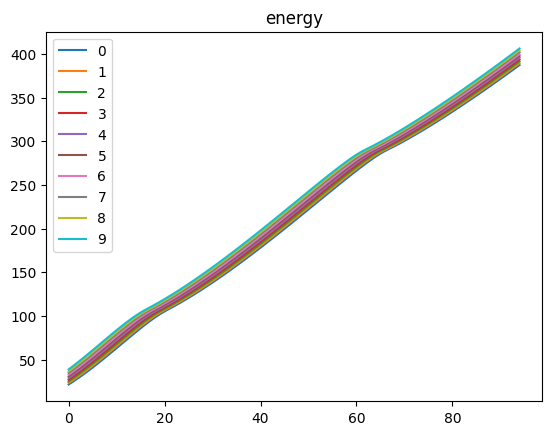

In [13]:
for l in range(10):
    centrifugal_poten=-b_lap*(l+1)*l/grid**2
    V_diag=potential(grid)+centrifugal_poten
    A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
    eigenvalues= torch.linalg.eigvalsh(A)
    real_en=eigenvalues[5:en_num]    
    plt.plot(real_en.detach().cpu().numpy(),label=str(l))

plt.legend()
plt.title("energy")
plt.show()

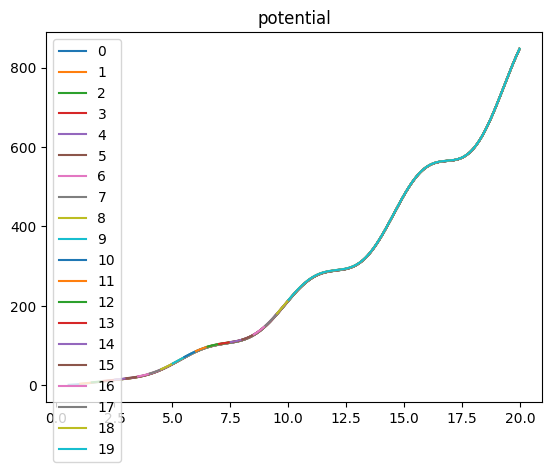

In [14]:
for l in range(20):
    grid=grid[20:]
    centrifugal_poten=-b_lap*(l+1)*l/grid**2
    V_diag=potential(grid)+centrifugal_poten
    plt.plot(grid.detach().cpu().numpy(),V_diag.detach().cpu().numpy(),label=str(l))
plt.legend()
plt.title("potential")
plt.show()